<h1><center>ОТБОР ПРИЗНАКОВ</center></h1>

Вернёмся к модели «Космолайна», предсказывающей отток клиентов. Вы уже обучили её базовую версию, а также вариант модели с дополнительными признаками. Чтобы улучшить качество предсказаний модели и увеличить скорость её работы в продакшене, избавьтесь от лишних признаков, используя методы, изученные в предыдущем уроке.

В начале определите глобальные переменные. Вот шаблон того, как это можно сделать:

In [ ]:
import pandas as pd
import numpy as np
import os
import psycopg
import mlflow
from mlflow.tracking import MlflowClient
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import ( OneHotEncoder, SplineTransformer, QuantileTransformer, StandardScaler,
                                    RobustScaler, PolynomialFeatures, KBinsDiscretizer )
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from autofeat import AutoFeatRegressor, AutoFeatClassifier

import catboost as cb
from catboost import CatBoostClassifier
from category_encoders import CatBoostEncoder

TABLE_NAME = "clean_users_churn" # таблица с данными
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "sign_selection" # название эксперимента
RUN_NAME = "sign_selection" 
REGISTRY_MODEL_NAME = "sign_selection" # название зарегистрированной модели 
FS_ASSETS = "fs_assets" 

experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)\
    if not mlflow.get_experiment_by_name(EXPERIMENT_NAME)\
    else mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

Далее загрузите данные для задачи оттока из таблицы в базе данных PostgreSQL и положите их в переменную df.

In [7]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {"host": 'rc1b-uh7kdmcx67eomesf.mdb.yandexcloud.net', #os.getenv("DB_DESTINATION_HOST"),
                        "port": '6432', #os.getenv("DB_DESTINATION_PORT"),
                        "dbname": 'playground_mle_20250529_05fed48463', #os.getenv("DB_DESTINATION_NAME"),
                        "user": 'mle_20250529_05fed48463', #os.getenv("DB_DESTINATION_USER"),
                        "password": '0c567edd8ad8472e87d5c85cc4d664e4' } #os.getenv("DB_DESTINATION_PASSWORD")}
connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)
df['target'] = (df['end_date'].notna()).astype(int)
df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,1,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,...,No,No,No,No,Female,0,Yes,No,No,0
1,2,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,...,Yes,No,No,No,Male,0,No,No,No,0


После того как вы выделили категориальные колонки, закодируйте их для подачи в вашу модель:

**Обучим модель**. Подготовим данные:


In [8]:
# Выделим признаки в три отдельные таблицы для дальнейшей работы:
features = df.drop(['customer_id','target'],axis=1)
num_features = features.select_dtypes(include=['float', 'int'])
date_features = features.select_dtypes(include='datetime64[ns]')
cat_features = features.select_dtypes(include='object')

# Посчитаем колво уникальных значений для катег. переменных и создадим создадим два датасета:
unique_values_per_col = cat_features.nunique().value_counts()
binary_cat_features = cat_features[ [i for i in cat_features.columns if cat_features[i].nunique()==2] ]
other_cat_features = cat_features[ [i for i in cat_features.columns if cat_features[i].nunique()!=2] ]

# Бинарные подразделяем на два - "да/нет" и другие бинарные:
yes_no_features = binary_cat_features[ [i for i in binary_cat_features.columns if\
binary_cat_features[i].isin(['Yes','yes','No','no',None,np.nan]).all()==True] ]
other_binary_features = binary_cat_features[ [i for i in binary_cat_features.columns if\
binary_cat_features[i].isin(['Yes','yes','No','no',None,np.nan]).all()!=True] ]

# Дубликаты
is_duplicated_id = df.duplicated(subset=['customer_id'], keep=False)

# Пропуски
cols_with_nans = df.isnull().sum()
cols_with_nans = cols_with_nans[cols_with_nans > 0].index.drop('end_date')
for col in cols_with_nans:
    if df[col].dtype in [float, int]:
        fill_value = df[col].mean()
    elif df[col].dtype == 'object':
        fill_value = df[col].mode().iloc[0]
    df[col] = df[col].fillna(fill_value)

# Выбросы
num_cols = df.select_dtypes(['float']).columns
threshold = 1.5
potential_outliers = pd.DataFrame()
for col in num_cols:
	Q1 = df[col].quantile(0.25)
	Q3 = df[col].quantile(0.75)
	IQR = Q3 - Q1
	margin = threshold * IQR
	lower = Q1 - margin
	upper = Q3 + margin
	potential_outliers[col] = ~df[col].between(lower, upper)
outliers = potential_outliers.any(axis=1)

df.drop(columns=['id', 'customer_id', 'begin_date', 'end_date'], inplace=True)
df[-3:]


,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
7016,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,No,0
7017,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes,1
7018,Two year,Yes,Bank transfer (automatic),105.65,6844.50,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Male,0,No,No,No,0


Обучим модель:

In [9]:

# Разделим данные на две части - для обучения и для проверки качества предсказания:
X_tr, X_val, y_tr, y_val = train_test_split(df, df['target'], stratify=df['target']) 

# Тренировочная выборка
cat_features_tr = X_tr.select_dtypes(include='object')
potential_binary_features_tr = cat_features_tr.nunique() == 2

binary_cat_features_tr = cat_features_tr[potential_binary_features_tr[potential_binary_features_tr].index]
other_cat_features_tr = cat_features_tr[potential_binary_features_tr[~potential_binary_features_tr].index]
num_features_tr = X_tr.select_dtypes(['float'])

# Валидационная выборка
cat_features_val = X_val.select_dtypes(include='object')
potential_binary_features_val = cat_features_val.nunique() == 2

binary_cat_features_val = cat_features_val[potential_binary_features_val[potential_binary_features_val].index]
other_cat_features_val = cat_features_val[potential_binary_features_val[~potential_binary_features_val].index]
num_features_val = X_val.select_dtypes(['float'])

binary_cols = binary_cat_features_tr.columns.tolist()
non_binary_cat_cols = other_cat_features_tr.columns.tolist()
num_cols = num_features_tr.columns.tolist()

# Определим список трансформаций в рамках ColumnTransformer
preprocessor = ColumnTransformer( [ ('binary', OneHotEncoder(drop='if_binary'), binary_cols),
                                    ('cat', CatBoostEncoder(), non_binary_cat_cols),
                                    ('num', StandardScaler(), num_cols) ],verbose_feature_names_out=False )

# Трансформируем исходные данные с помощью созданного preprocessor
X_tr_transformed = preprocessor.fit_transform(X_tr, y_tr)
X_val_transformed = preprocessor.transform(X_val)

# Создадим модель:
model = CatBoostClassifier()

# Обучим модель:
model.fit(X_tr_transformed, y_tr)

Learning rate set to 0.020938
0:	learn: 0.6791366	total: 62.3ms	remaining: 1m 2s
1:	learn: 0.6673208	total: 65.1ms	remaining: 32.5s
2:	learn: 0.6550343	total: 67.9ms	remaining: 22.6s
3:	learn: 0.6434825	total: 70.5ms	remaining: 17.6s
4:	learn: 0.6326619	total: 74ms	remaining: 14.7s
5:	learn: 0.6224657	total: 76.6ms	remaining: 12.7s
6:	learn: 0.6132499	total: 79.3ms	remaining: 11.2s
7:	learn: 0.6040662	total: 82.1ms	remaining: 10.2s
8:	learn: 0.5941235	total: 85ms	remaining: 9.36s
9:	learn: 0.5861332	total: 87.6ms	remaining: 8.67s
10:	learn: 0.5774780	total: 90.3ms	remaining: 8.12s
11:	learn: 0.5689208	total: 93ms	remaining: 7.66s
12:	learn: 0.5608701	total: 95.7ms	remaining: 7.26s
13:	learn: 0.5543577	total: 98.3ms	remaining: 6.93s
14:	learn: 0.5486060	total: 101ms	remaining: 6.63s
15:	learn: 0.5417749	total: 104ms	remaining: 6.37s
16:	learn: 0.5361839	total: 106ms	remaining: 6.15s
17:	learn: 0.5306538	total: 109ms	remaining: 5.95s
18:	learn: 0.5257378	total: 112ms	remaining: 5.77s
19:

Проверим качество нашей модели:

In [10]:
# Сделаем предсказание:
y_val_pred = model.predict(X_val_transformed)

# Определим точность:
accuracy = str(accuracy_score(y_val, y_val_pred))[:4]
print(f"Точность модели: {accuracy}")

Точность модели: 0.79


Напомним, что отбор признаков важно проводить на обучающем наборе данных, чтобы исключить переобучение.
<br>Для отбора признаков используйте библиотеку mlxtend и методы Sequential Forward Selection (SFS) и Sequential Backward Selection (SBS).

---

**Задание 1**

Отберите десять лучших признаков при помощи методов SFS и SBS. Используйте такие настройки:
- параметр кросс-валидации равен 4;
- функция floating=False, то есть выключена;
- в качестве оценщика используйте алгоритм случайного леса c числом деревьев 300, а основной метрикой будет roc_auc.

Имена отобранных признаков сохраните в переменные top_sfs и top_sbs.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

estimator = RandomForestClassifier(n_estimators=300) # ваш код здесь #
print('estimator')

sfs = SFS(estimator, k_features=10, forward=True, floating=False, scoring='roc_auc', cv=4, n_jobs=-1) # ваш код здесь #
print('sfs')
sbs = SFS(estimator, k_features=10, forward=False, floating=False, scoring='roc_auc', cv=4, n_jobs=-1) # ваш код здесь #
print('sbs')

sfs = sfs.fit(X_tr_transformed, y_tr) # ваш код здесь # запустите отбор признаков
print('sfs2')
sbs = sbs.fit(X_tr_transformed, y_tr) # ваш код здесь #
print('sbs2')

top_sfs = sfs.k_feature_names_ # ваш код здесь #
print('top_sfs')
top_sbs = sbs.k_feature_names_ # ваш код здесь #
print('top_sbs')

print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)

estimator
sfs
sbs
sfs2
sbs2
top_sfs
top_sbs

Sequential Forward Selection (k=10)
CV Score:
0.8185330307726268

Sequential Backward Selection
CV Score:
0.8215723174062792


Отбор признаков — тоже исследование, и его результаты важно сохранять. После того как вы запустили sfs.fit() или sbs.fit(), на выходе получаются объекты sfs_df и sbs_df, из которых просто получить таблицу с результатами отбора. Сделать это можно так: 

In [12]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

Сохраните этот датафрейм в CSV-файл для каждого из методов отбора признаков:

In [14]:
# os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

Постройте графики отбора признаков для методов SFS и SBS и сохраните графики в директорию с артефактами.
Начнём с SFS. 

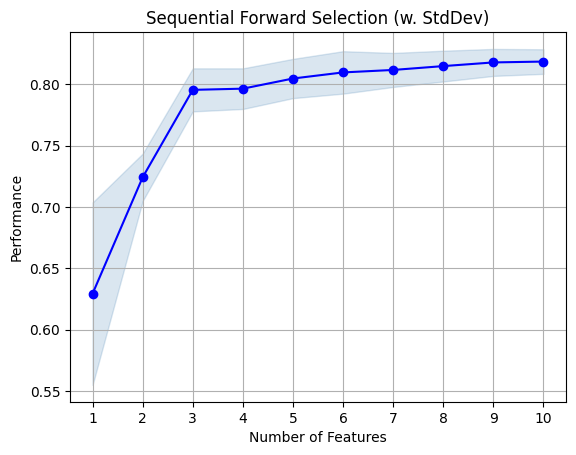

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png") 

График визуализирует процесс последовательного прямого отбора признаков SFS с указанием стандартного отклонения StdDev. По оси x — количество признаков, по оси y — производительность модели. Очевидно, что с увеличением числа признаков производительность повышается, особенно заметен рост при добавлении первых нескольких признаков. Но примерно после добавления пяти признаков улучшение замедляется и стабилизируется.


Теперь график SBS.

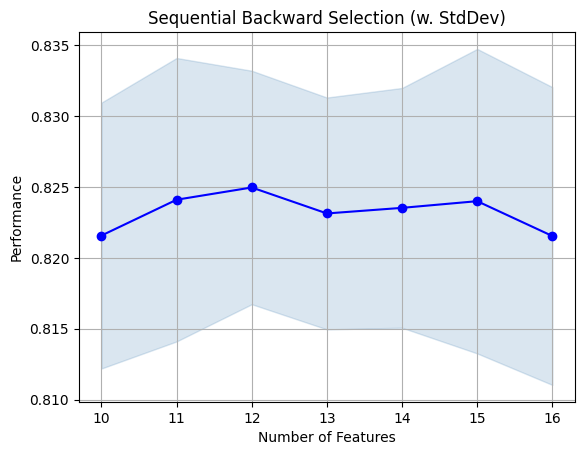

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png") 

**Задание 2**

Создайте два списка list в Python, в которых будут храниться признаки, отобранные путём пересечения и объединения. Файл для пересекающихся множеств назовите interc_features, для объединяющихся — union_features.
Для проверки решения вернитесь в это задание и нажмите кнопку Проверить.

In [17]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

In [ ]:
# experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

# with mlflow.start_run(run_name=f"{RUN_NAME}", experiment_id=experiment_id) as run:
#     run_id = run.info.run_id
   
#     mlflow.log_artifacts(FS_ASSETS)

Регистрируем:

In [28]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = 'https://storage.yandexcloud.net'
os.environ["AWS_ACCESS_KEY_ID"] = "YCAJE3Nlz8iDILW5VTYM1ihQB"
os.environ["AWS_SECRET_ACCESS_KEY"] = "YCPjvS7uwhvJpUj3bKm8X-IX4QAwBIVsvX61IL44"
os.environ['MLFLOW_ARTIFACT_URI'] = 'http://s3-student-mle-20250529-05fed48463'

TRACKING_SERVER_HOST = '127.0.0.1'
TRACKING_SERVER_PORT = 5000

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.sklearn.log_model(model, REGISTRY_MODEL_NAME)
    model_registred_name = REGISTRY_MODEL_NAME
    mlflow.register_model("runs:/{}/model".format(run.info.run_id), model_registred_name)
    # model_version_id = mlflow.get_latest_versions(model_registred_name)[0].version
    run_id = run.info.run_id
    mlflow.log_artifacts(FS_ASSETS)

2025-07-21 15:43:29,569 INFO: Found credentials in environment variables.
Successfully registered model 'sign_selection'.
2025/07/21 15:43:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sign_selection, version 1
Created version '1' of model 'sign_selection'.


**Задание 4**


Теперь обучите две версии модели на двух наборах признаков и сравните метрики. Зарегистрируйте обе модели в MLflow в экспериментах feature_selection_union и feature_selection_intersection. В переменные ниже вставьте соответствующую информацию.